## Title: Classifying the age of tennis players based on match statistics

## Introduction:

The ATP Tour is a worldwide tennis competition organized for men. The tournament spans over a calendar year and across more than 30 countries. Qualifications for these games are determined through tennis rankings, which are points earned by players in official ATP-certified events, with the best 19 results counted. Tennis matches, on average lasting 165 minutes, serve as a rigorous test of a player's resilience and strategy, which stem from a combination of talent and accumulated experience. 

In addition to player ranking and match duration, some other factors that come into play include a player's height, where taller players tend to position themselves in the forefield, while shorter players exhibit greater mobility. Furthermore, the serve points, the points earned in a player's service round, stand as a crucial criterion for evaluating a winner's ability, of whether that player can seize the opportunity to gain an advantage in their serve game.

These factors underpin our research question: Can the age range of a winning player be predicted based on these multifaceted match statistics? To address this query, we used the atp2017-2019 database, which contains comprehensive data on all players and match points from 2017 to 2019. The analysis will only be performed on players at the Grand Slam tourney level and best-of-5 match for an equal comparison. 

## Methods and Results:

#### Import data from Web

In [66]:
library(repr)
library(tidyverse)
library(tidymodels)
install.packages("ggplot2")       
install.packages("GGally")
library("ggplot2")                     
library("GGally")
install.packages("cowplot")
library(cowplot)
install.packages("kknn")
options(repr.plot.width = 10, repr.plot.height = 8)
options(repr.matrix.max.rows = 10)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [67]:
url <- "https://raw.githubusercontent.com/Windy-Huang/DSCI-100-009-22/main/atp2017-2019.csv"
tennis_data <- read_csv(url)

head(tennis_data)
print("Table 1. A preview of the entire dataset")

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1 tourney_id tourney_name surface draw_size tourney_level tourney_date
1 0    2019-M020  Brisbane     Hard    32        A             20181231    
2 1    2019-M020  Brisbane     Hard    32        A             20181231    
3 2    2019-M020  Brisbane     Hard    32        A             20181231    
4 3    2019-M020  Brisbane     Hard    32        A             20181231    
5 4    2019-M020  Brisbane     Hard    32        A             20181231    
6 5    2019-M020  Brisbane     Hard    32        A             20181231    
  match_num winner_id winner_seed ⋯ l_1stIn l_1stWon l_2ndWon l_SvGms l_bpSaved
1 300       105453    2           ⋯ 54      34       20       14      10       
2 299       106421    4           ⋯ 52      36        7       10      10       
3 298       105453    2           ⋯ 27      15        6        8       1       
4 297       104542    NA          ⋯ 60      38        9       11       4       
5 296       106421    4           ⋯ 56      46       19       15       2       
6 295       104871    NA          ⋯ 54      40       18       15       6       
  l_bpFaced winner_rank winner_rank_points loser_rank loser_rank_points
1 15          9         3590                16        1977             
2 13         16         1977               239         200             
3  5          9         3590                40        1050             
4  6        239          200                31        1298             
5  4         16         1977                18        1855             
6  9         40         1050               185         275

[1] "Table 1. A preview of the entire dataset"


#### Data Wrangling

After loading the dataset, we proceeded with the process of data wrangling. This involved selecting columns and filtering rows for relevant data based on the criteria outlined in the introduction. Given our objective of this study is to classify the winner's age, an important step is to convert the age column from a quantitative into a categorical variable.

It is noteworthy that our dataset contains 25% of missing values (NA). However, since the percentage of missing values in the dataset does not surpass the threshold of 30%, we settled on not replacing them with the mean of the data. Nevertheless, to ensure the integrity of our subsequent data analysis, we systematically eliminated all instances of missing values to avoid potential interference with the analytical procedures.

In [68]:
tennis_selected <- tennis_data |>
    select(tourney_level, winner_name, winner_age, winner_rank, minutes, best_of, w_svpt, winner_ht)

tennis_filtered_tourney_level <- tennis_selected |>
    filter(tourney_level == "G")

tennis_factored <- tennis_filtered_tourney_level |>
    mutate(age = ifelse(winner_age <= 30, "Under 30", "Over 30")) |>
    mutate(age = factor(age, levels=c("Under 30", "Over 30"))) |>
    select(-best_of)

tennis_na_removed <- tennis_factored |>
    drop_na()

na_value <- nrow(tennis_factored) - nrow(tennis_na_removed)

head(tennis_na_removed)
print("Table 2. A preview of the tidied dataset.")
print(paste("The number of NA in this dataset is", na_value, "rows or", na_value/nrow(tennis_factored)*100, "percent."))

tourney_level winner_name        winner_age winner_rank minutes w_svpt
1 G             Novak Djokovic     31.64956     1         123      65   
2 G             Jo Wilfried Tsonga 33.74401   177         146      89   
3 G             David Goffin       28.10404    22          88      62   
4 G             Marius Copil       28.24367    60         105      88   
5 G             Ryan Harrison      26.68857    83          99      66   
6 G             Fabio Fognini      31.64408    13         144     102   
  winner_ht age     
1 188       Over 30 
2 188       Over 30 
3 163       Under 30
4 193       Under 30
5 183       Under 30
6 178       Over 30

[1] "Table 2. A preview of the tidied dataset."
[1] "The number of NA in this dataset is 316 rows or 25 percent."


#### Data splitting

Before undertaking any preliminary analysis, the dataset was divided into a balanced 75% training and 25% testing split. The decision to segregate the testing set from the data analysis ensures the testing set serves as a fair and unbiased evaluation of the performance of our analytical models.

In [69]:
set.seed(99)
tennis_split <- initial_split(tennis_na_removed, prop=0.75, strata=age)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

head(tennis_training)
print("Table 3. A preview of the training set")

tourney_level winner_name           winner_age winner_rank minutes w_svpt
1 G             Novak Djokovic        31.64956    1          123      65   
2 G             Fabio Fognini         31.64408   13          144     102   
3 G             Philipp Kohlschreiber 35.24709   32          120      90   
4 G             Ivo Karlovic          39.87680   73          186     158   
5 G             Jeremy Chardy         31.92060   36          244     187   
6 G             Gilles Simon          34.04791   30          127      93   
  winner_ht age    
1 188       Over 30
2 178       Over 30
3 178       Over 30
4 208       Over 30
5 188       Over 30
6 183       Over 30

[1] "Table 3. A preview of the training set"


#### Data summary in table

In order to familiarize readers with the dataset, we have presented a summary in tabular form. These tables showcase the number and percentage of observations within each age category, accompanied by their corresponding mean rank, match time, height, and serve points. It is interesting to note from our summary table that younger winners tend to have higher ranks, longer match times, and higher serve points, while older winners typically display lower ranks and shorter match durations. This pattern hints to a hypothesis that performance may begin to decline for individuals beyond the age of 30.

In [70]:
rank <- tennis_training |>
    group_by(age) |>
    summarize(mean_rank=mean(winner_rank))

time <- tennis_training |>
    group_by(age) |>
    summarize(mean_match_time=mean(minutes))

height <- tennis_training |>
    group_by(age) |>
    summarize(mean_height=mean(winner_ht))

serve_points <- tennis_training |>
    group_by(age) |>
    summarize(mean_serve_points=mean(w_svpt))

stats <- tennis_training |>
    group_by(age) |>
    summarize(count=n()) |>
    mutate(percentage = count/nrow(tennis_training)) |>
    inner_join(rank) |>
    inner_join(time) |>
    inner_join(height) |>
    inner_join(serve_points)

stats
print("Table 4. The mean of each predictor with respect to each category of age")

Joining with `by = join_by(age)`
Joining with `by = join_by(age)`
Joining with `by = join_by(age)`
Joining with `by = join_by(age)`


age      count percentage mean_rank mean_match_time mean_height
1 Under 30 348   0.4901408  35.29023  151.1207        185.4914   
2 Over 30  362   0.5098592  32.90608  146.7403        188.6492   
  mean_serve_points
1 109.5489         
2 104.0801

[1] "Table 4. The mean of each predictor with respect to each category of age"


#### Data visualization
To further explore the dataset and uncover potential trends, we visualized the selected predictors first using a pairplot. The advantage of pairplot is that it allows readers to visualize the overall relationships between multiple variables simultaneously.
 
Next, we zoom into the details by using both scatter plots and line graphs. One of our visualizations will be a scatter plot; we will display the game duration in minutes on the x-axis and the other 3 predictors in turn on the y-axis. The points will be colored to show the age range of the winners, distinguishing between those over or under 30. While a significant portion of data points cluster in a similar region, subtle differences emerge upon closer inspection. 

As for the line graph, we introduced a vertical line highlighting the division between the 2 age categories, reinforcing how performance peaks around this age range. Observable trends of increasing performance are on the left, and declining performance is on the right, which aligns with the previous studies suggesting a decrease in physical ability in the late 20s. Based on this, we will use classification to help predict the age range of the winners of games.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] "Figure 1. A pairplot of the 4 interested predictors"


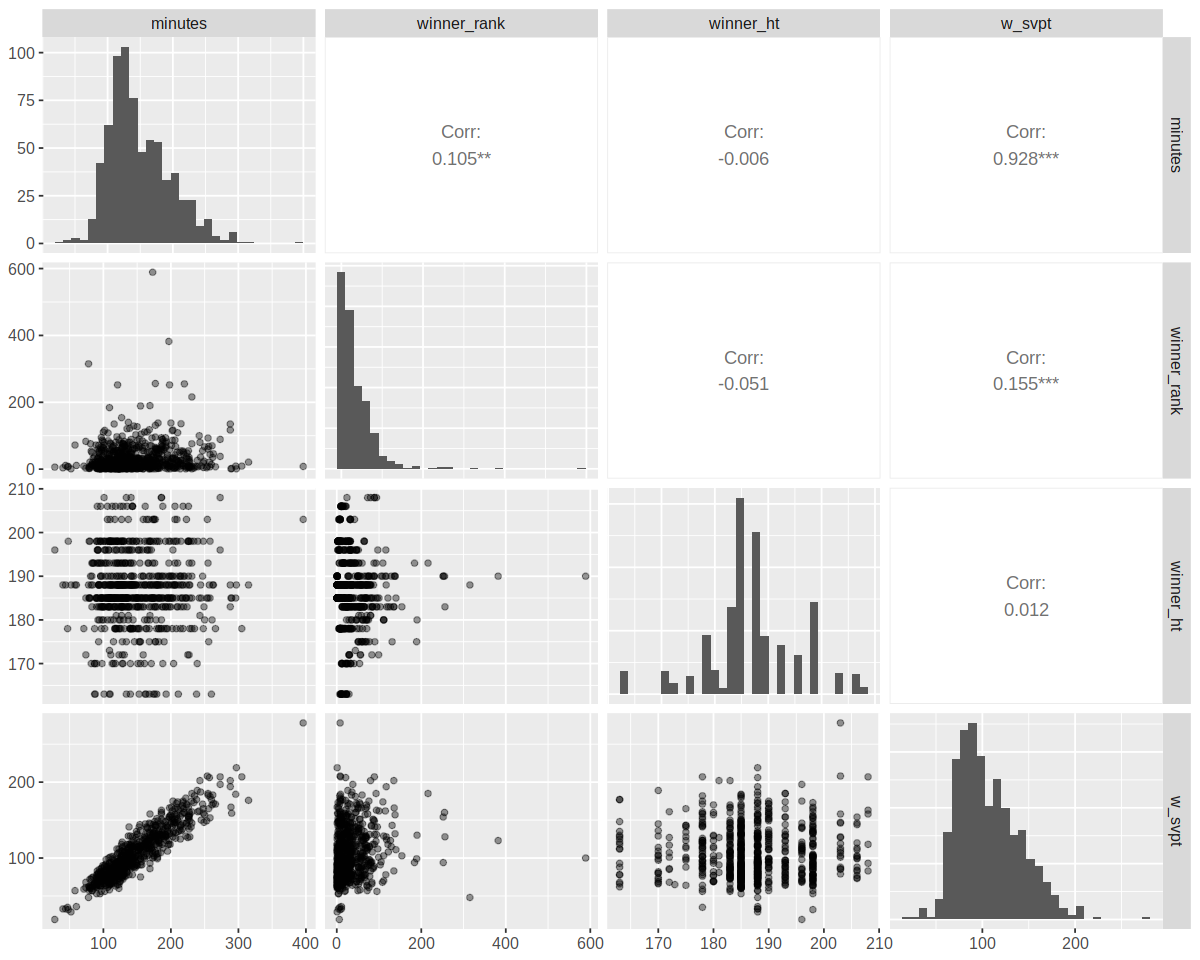

In [71]:
pairplot <- tennis_training |> 
     select(minutes, winner_rank, winner_ht, w_svpt) |>
     ggpairs(
         lower = list(continuous = wrap('points', alpha = 0.4)),
         diag = list(continuous = "barDiag")
     ) +
     theme(text = element_text(size = 12))

pairplot
print("Figure 1. A pairplot of the 4 interested predictors")

Analyzing the ggpair plot above, it becomes evident that the majority of scatter points plots exhibit no clear relationship between the x and y predictors, as shown by the clusters in the data. However, an exception is observed in the relationship between winner serve points and minutes, revealing a strong positive and linear pattern. This suggests that these predictors might be ideal for our analysis. The strength of this association is supported by the Pearson correlation coefficient, which stands at 0.928, demonstrating a clear positive linear relationship. In contrast, the correlation coefficients for the remaining predictors are near zero, indicating negligible relationships.

Shifting the focus to the histograms, the central tendency of the four distributions is skewed to the left side of the graph, deviating from the traditional normal distribution curve. After exploring the connections between predictors, we will further explore how the classifier is distributed among these predictors.

[1] "Figure 2. The relationship of winner rank with respect to game duration and winner age"


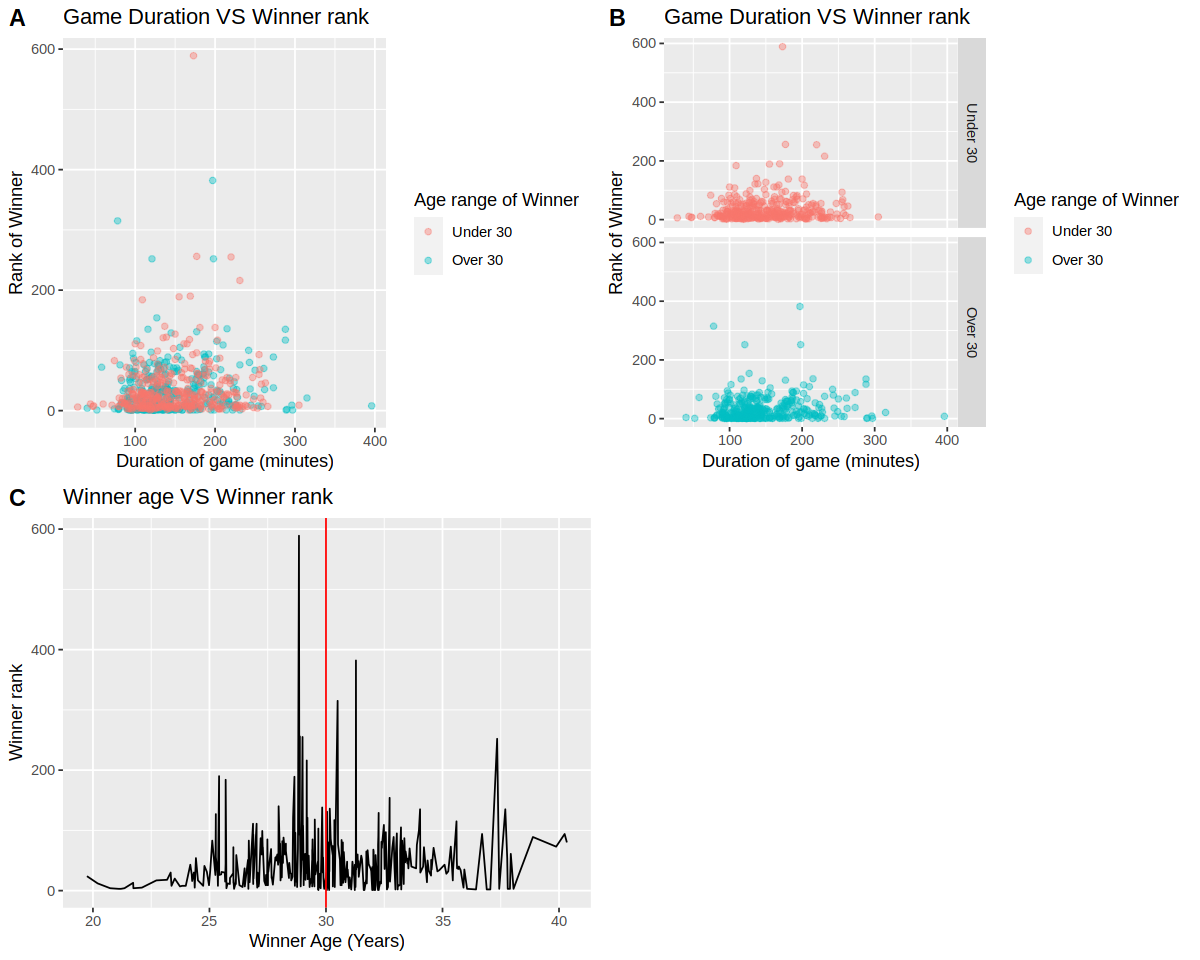

In [72]:
match_plot <- tennis_training |>
    ggplot(aes(x=winner_age, y=winner_rank)) +
    geom_line() +
    geom_vline(xintercept=30, color="red") +
    labs(x="Winner Age (Years)",
         y="Winner rank") +
    ggtitle("Winner age VS Winner rank")

tennis_plot <- tennis_training |>
    ggplot(aes(x=minutes, y=winner_rank, color=age)) +
    geom_point(alpha=0.4) +
    labs(x="Duration of game (minutes)",
         y="Rank of Winner",
         color="Age range of Winner") +
    ggtitle("Game Duration VS Winner rank")

tennis_facet <- tennis_plot +
    facet_grid(rows=vars(age))

plot_grid(tennis_plot, tennis_facet, match_plot,
          labels = c("A","B", "C"),
          ncol = 2, nrow = 2)
print("Figure 2. The relationship of winner rank with respect to game duration and winner age")

[1] "Figure 3. The relationship of winner serve points with respect to game duration and winner age"


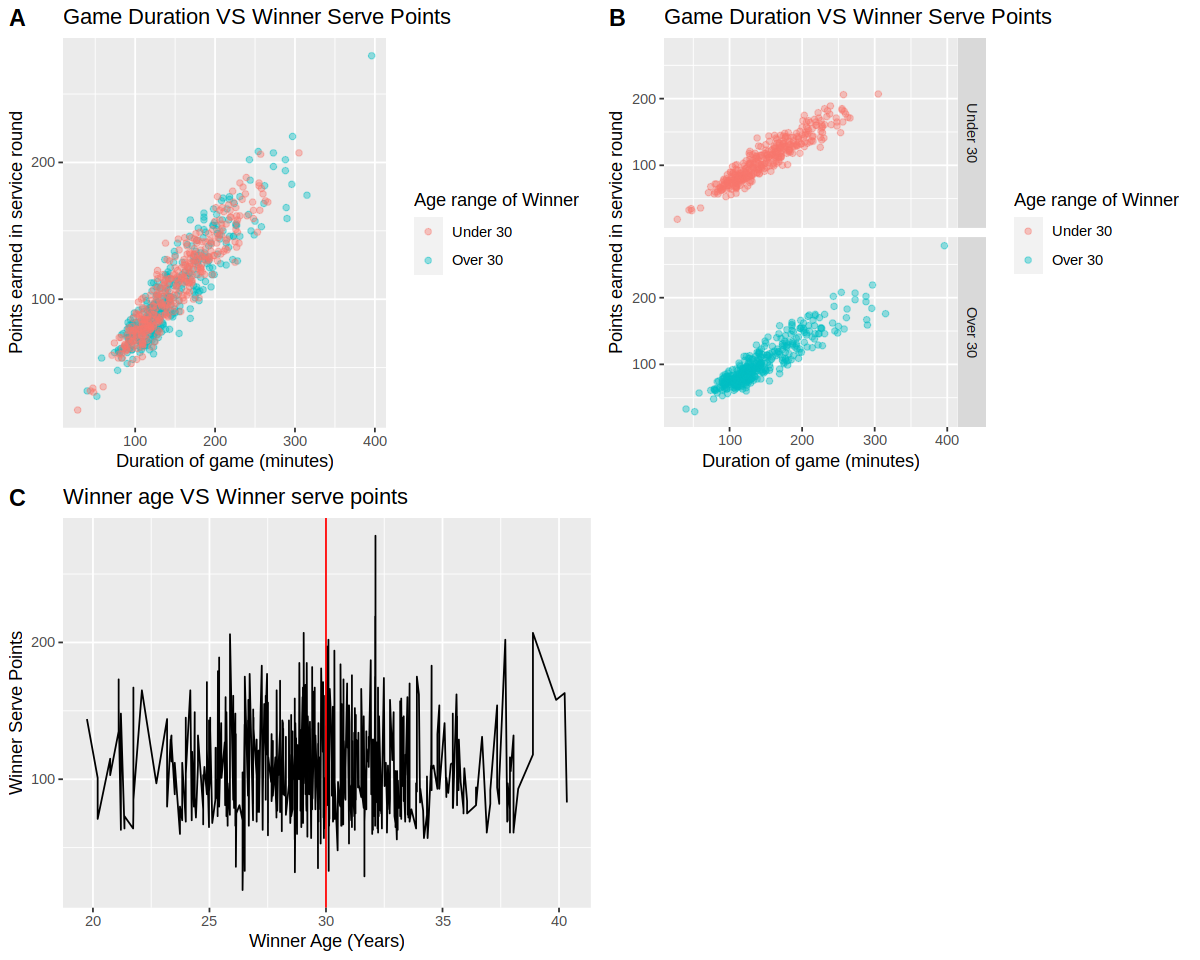

In [73]:
match_plot <- tennis_training |>
    ggplot(aes(x=winner_age, y=w_svpt)) +
    geom_line() +
    geom_vline(xintercept=30, color="red") +
    labs(x="Winner Age (Years)",
         y="Winner Serve Points") +
    ggtitle("Winner age VS Winner serve points")

tennis_plot <- tennis_training |>
    ggplot(aes(x=minutes, y=w_svpt, color=age)) +
    geom_point(alpha=0.4) +
    labs(x="Duration of game (minutes)",
         y="Points earned in service round",
         color="Age range of Winner") +
    ggtitle("Game Duration VS Winner Serve Points")

tennis_facet <- tennis_plot +
    facet_grid(rows=vars(age))

plot_grid(tennis_plot, tennis_facet, match_plot,
          labels = c("A","B", "C"),
          ncol = 2, nrow = 2)
print("Figure 3. The relationship of winner serve points with respect to game duration and winner age")

[1] "Figure 4. The relationship of winner height with respect to game duration and winner age"


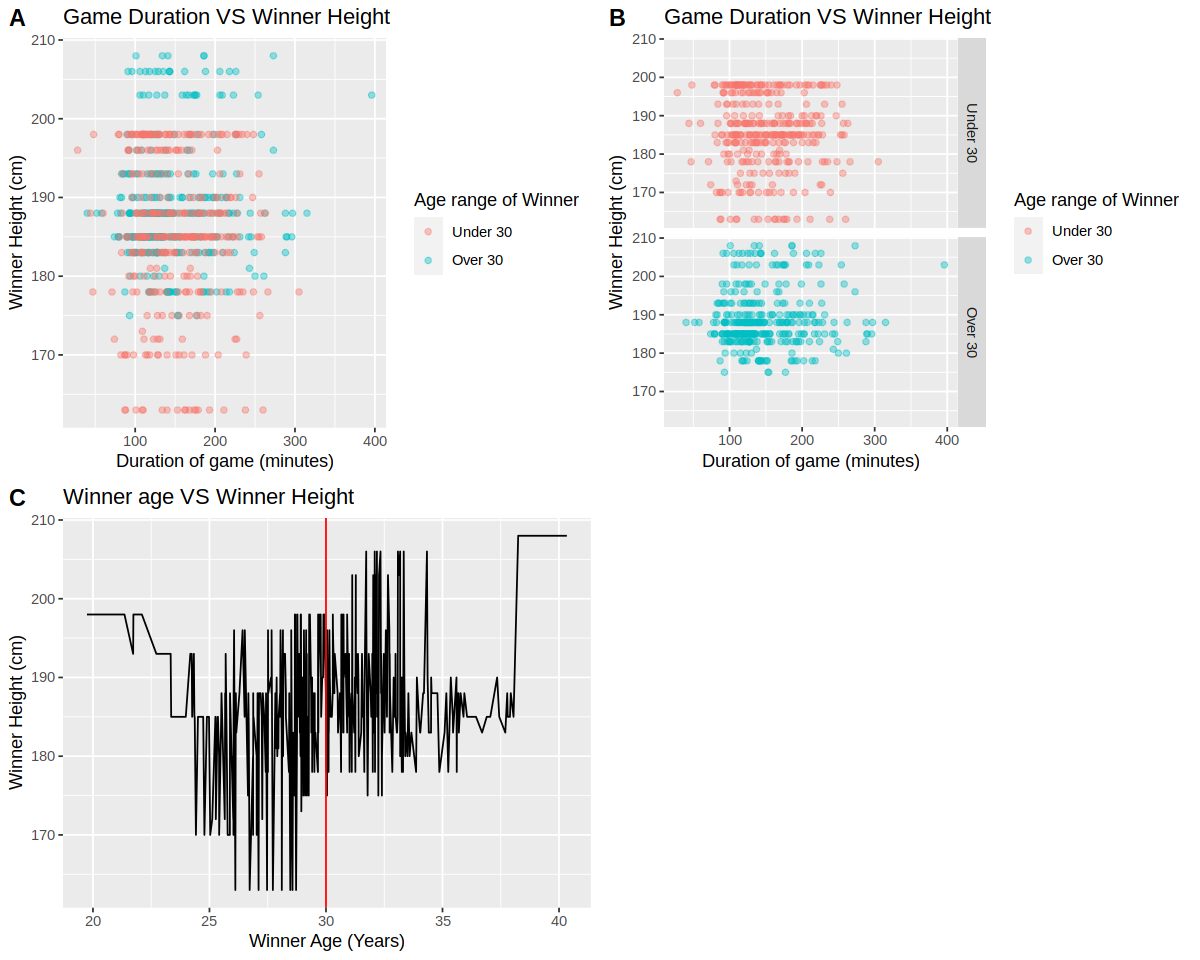

In [74]:
match_plot <- tennis_training |>
    ggplot(aes(x=winner_age, y=winner_ht)) +
    geom_line() +
    geom_vline(xintercept=30, color="red") +
    labs(x="Winner Age (Years)",
         y="Winner Height (cm)") +
    ggtitle("Winner age VS Winner Height")

tennis_plot <- tennis_training |>
    ggplot(aes(x=minutes, y=winner_ht, color=age)) +
    geom_point(alpha=0.4) +
    labs(x="Duration of game (minutes)",
         y="Winner Height (cm)",
         color="Age range of Winner") +
    ggtitle("Game Duration VS Winner Height")

tennis_facet <- tennis_plot +
    facet_grid(rows=vars(age))

plot_grid(tennis_plot, tennis_facet, match_plot,
          labels = c("A","B", "C"),
          ncol = 2, nrow = 2)
print("Figure 4. The relationship of winner height with respect to game duration and winner age")

Observing Figures 2, 3, and 4, contrary to our initial expectations, it appears that minutes and winner serve points do not emerge as the ideal predictors. Despite a strong positive linear relationship, the two categories are bundled together, which presents a challenge for the model to distinguish between them. A similar clustering effect is observed for winner rank as well. 

However, the winners' height, in contrast, appears to offer more distinct differences. There is a discernible cluster each for players above or below 30, as well as a region where players from both categories mix. Overall, the winners' height emerges as a potentially more ideal predictor, and this insight will influence the choice of the model design.

#### Data Analysis

During the preliminary data analysis, our group selected four predictors; however, contrary to intuition, the highest accuracy in predictive modeling is not consistently associated with the highest number of predictors. Therefore, to determine the optimal number of predictors for our model, we systematically added predictors one by one using a for loop. 

The ordering of when each predictor is included is based on our observations from the visual preliminary analysis. Given that winner_ht exhibited the most significant difference, it was positioned at the forefront of the list. As for the other predictors, since minimal contradiction was observed, the specific order of inclusion was not a crucial consideration, as either order would yield a similar effect.

This iterative process allowed us to explore and identify the most effective combination of predictors and k values for our model. 

In [77]:
set.seed(80)

tennis_set <- select(tennis_training, -winner_age) |>
    select(-tourney_level) |>
    select(-winner_name)

names <- colnames(tennis_set |> select(-age))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric(),
                     k_value = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

tennis_vfold <- vfold_cv(tennis_set, v = 5, strata = age)

n_total <- length(names)

selected <- c()

k_val=tibble(neighbors=seq(from=1, to=50, by=5))

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    k <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("age", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        tennis_recipe <- recipe(as.formula(model_string), 
                                data = tennis_set) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())
        
          acc <- workflow() |>
          add_recipe(tennis_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = tennis_vfold, grid = k_val) |>
          collect_metrics() |>
          filter(.metric == "accuracy")
        a2 <- acc|>
          summarize(mx = max(mean))
        a <- a2$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- a
        models[[j]] <- model_string
        k[[j]] <- acc |>
            arrange(desc(mean)) |>
            slice(1) |>
            pull(neighbors)
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]],
              k_value = k[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
  }

accuracies
print("Table 5. A table illustrating the maxmimum accuracy possible with each number of predictor")

size model_string                               accuracy  k_value
1 1    age ~ winner_ht                            0.6663629 46     
2 2    age ~ winner_ht+winner_rank                0.8198206  1     
3 3    age ~ winner_ht+winner_rank+w_svpt         0.7057414  1     
4 4    age ~ winner_ht+winner_rank+w_svpt+minutes 0.6845740  6

[1] "Table 5. A table illustrating the maxmimum accuracy possible with each number of predictor"


Analyzing the results table, table 5, it became evident that our model achieved the highest accuracy when using two predictors. However, it is crucial to highlight that this accuracy was associated with a k value of 1, indicating significant overfitting. Consequently, such a model may not generalize well to the testing set or real-world data. Therefore, we favored a model with four predictors, as it possessed a more reasonable k value and the reasonably high accuracy.

#### Model Training

Subsequently, we reconstructed the model using the four-predictor k-nearest neighbors (knn) classification, refining it by tuning with specific k values less than 10. This decision stemmed from our prior data analysis, suggesting that the optimal k value was likely near the number 6. Following this, we evaluated the model's performance against the testing set and summarized the results in a confusion matrix.

neighbors .metric  .estimator mean      n std_err    .config              
1   1        accuracy binary     0.6718582 5 0.01721059 Preprocessor1_Model01
2   2        accuracy binary     0.6718582 5 0.01721059 Preprocessor1_Model02
3   3        accuracy binary     0.6423285 5 0.01419986 Preprocessor1_Model03
4   4        accuracy binary     0.6423285 5 0.01419986 Preprocessor1_Model04
5   5        accuracy binary     0.6633968 5 0.01251484 Preprocessor1_Model05
6   6        accuracy binary     0.6633968 5 0.01251484 Preprocessor1_Model06
7   7        accuracy binary     0.6774521 5 0.01908495 Preprocessor1_Model07
8   8        accuracy binary     0.6774521 5 0.01908495 Preprocessor1_Model08
9   9        accuracy binary     0.6675822 5 0.01594933 Preprocessor1_Model09
10 10        accuracy binary     0.6675822 5 0.01594933 Preprocessor1_Model10

[1] "Table 6. A table showing the statistics achieved using k values from 1 to 10"
[1] "Figure 5. A graph outlining the relationship between the number of neighbor and the model accuracy"


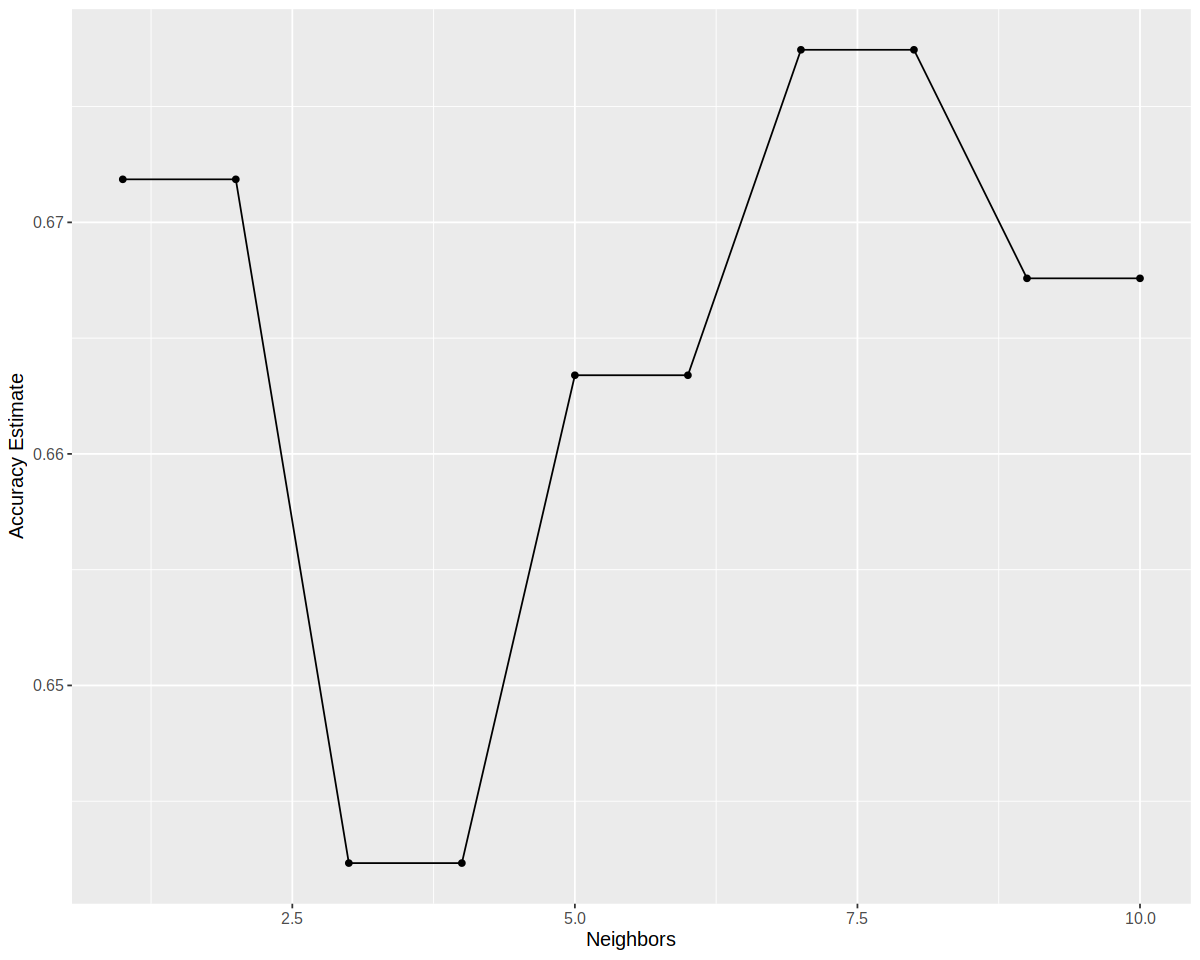

In [78]:
set.seed(999)

tennnis_recipe <- recipe(age ~ winner_ht + w_svpt + minutes + winner_rank, data= tennis_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

tennis_vfold <- vfold_cv(tennis_training, v = 5, strata = age)

t_spec <- nearest_neighbor(weight_func="rectangular",
                          neighbors=tune()) |>
    set_engine("kknn")|>
    set_mode("classification")

t_vals <- tibble(neighbors = 1:10)

t_result <- workflow() |>
    add_recipe(tennnis_recipe) |>
    add_model(t_spec) |>
    tune_grid(resamples = tennis_vfold, grid = t_vals) |>
    collect_metrics()

accuracies <- t_result |>
    filter(.metric=="accuracy")

accuracies
print("Table 6. A table showing the statistics achieved using k values from 1 to 10")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))

accuracy_vs_k
print("Figure 5. A graph outlining the relationship between the number of neighbor and the model accuracy")

tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7)|>
    set_engine("kknn") |>
    set_mode("classification")

tennis_fit <- workflow()|>
    add_recipe(tennnis_recipe) |>
    add_model(tennis_spec) |>
    fit(data = tennis_training)

Referring to Figure 4, it is evident that the optimal k value for our model is 7. Thus, our final model is implemented with a neighbor value of 7 and includes all the four selected predictors.

#### Model Evaluation

In order to critically assess the performance of our model, we tasked it with to predict the testing set, then compared these predictions against the actual values. The resulting statistics were summarized in a confusion matrix, providing readers with a visual representation of true positives, true negatives, false positives, and false negatives.

In [79]:
tennis_test_predictions <- predict(tennis_fit , tennis_testing) |>
    bind_cols(tennis_testing) |>
    conf_mat(truth=age,estimate=.pred_class) 

tennis_test_predictions
print("Figure 6. The confusion matrix of the model")
print(paste("Accuracy =", round((77+81)/(77+81+40+40), digits=3)))
print(paste("Precision =", round((77)/(77+40), digits=3)))
print(paste("Recall =", round((77)/(77+40), digits=3)))

          Truth
Prediction Under 30 Over 30
  Under 30       77      40
  Over 30        40      81

[1] "Figure 6. The confusion matrix of the model"
[1] "Accuracy = 0.664"
[1] "Precision = 0.658"
[1] "Recall = 0.658"


Observing the low performance of our model, our team wants to identify where the incorrect predictions occurred. To achieve this, we used the most ideal scatter plot identified in the preliminary analysis as a foundation, and we divided the graphs into two sections based on actual observation. Then, we utilized color to represent our model's predictions, which allowed us to gain insights into the specific instances where our model deviated from accurate predictions.

[1] "Figure 7. On game duration VS winner height scatter plot, the difference between prediction and observation is ploted."


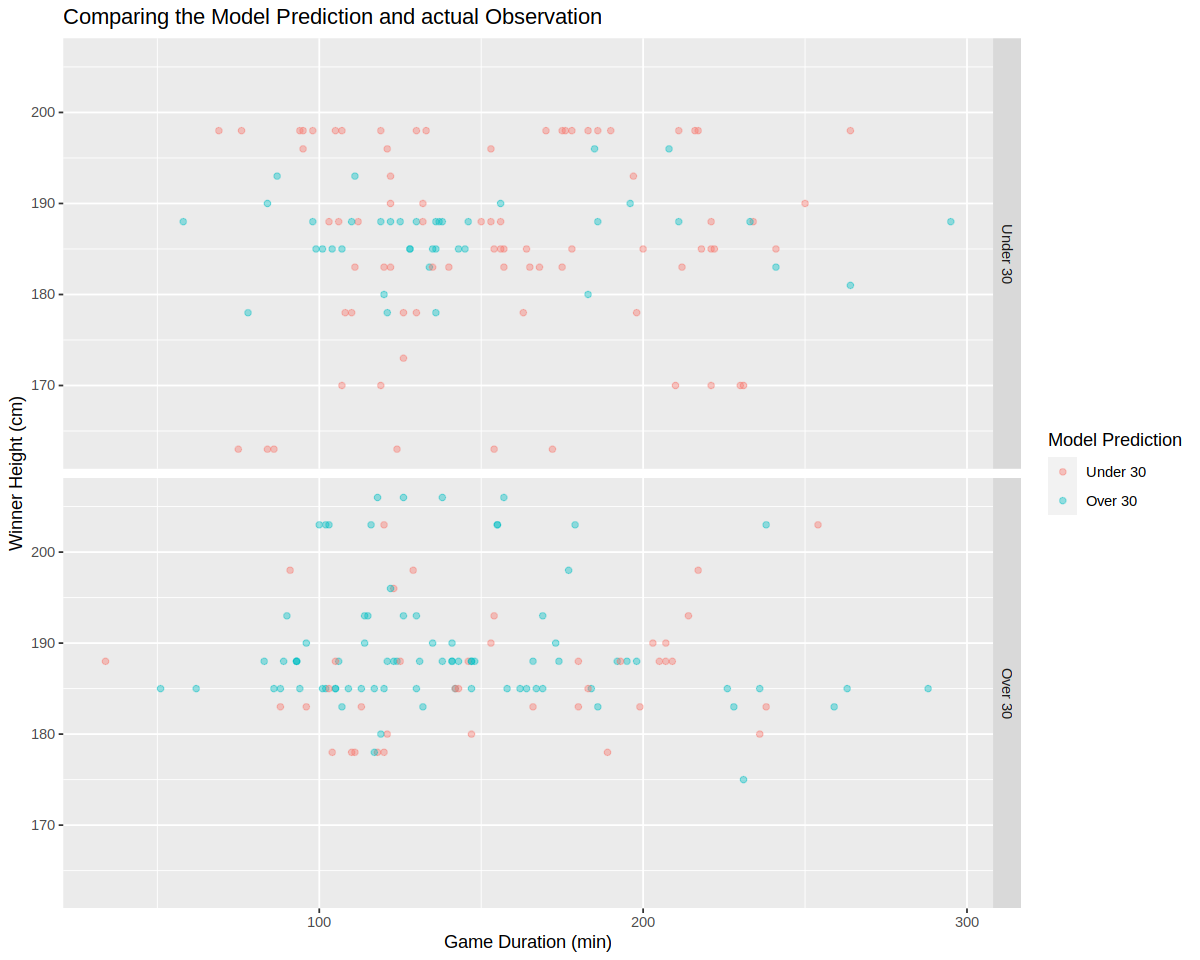

In [80]:
tennis_test_predictions <- predict(tennis_fit , tennis_testing) |>
    bind_cols(tennis_testing)

difference_plot <- tennis_test_predictions |>
    ggplot(aes(x=minutes, y=winner_ht, color=.pred_class)) +
    geom_point(alpha=0.4) +
    facet_grid(vars(cols=age)) +
    labs(x="Game Duration (min)", y="Winner Height (cm)", color="Model Prediction") +
    ggtitle("Comparing the Model Prediction and actual Observation")

difference_plot
print("Figure 7. On game duration VS winner height scatter plot, the difference between prediction and observation is ploted.")

By inspecting the top region of the plot, it is clear that the inaccuracies are concentrated in the center of the data instead of occurring at the extremes (outside boundaries). This finding is less evident in the lower part of the graph, as the errors are spread throughout.

This observation appears to correlate with our earlier insight from Figure 4, where there were distinct clusters for each category in the upper and lower part of the graph, while the middle exhibited a mix of data. This potential explanation indicates that the challenge lies in accurately predicting outcomes for cases where the data is more clustered and less distinct.

## Discussion

Observing our model's precision and recall, we noted that they were identical, which means this model predicts the same number of false positives and false negatives. One potential explanation may be that it is the effects of overfitting and stems from the inherent clustering in our original data. Overall, our model exhibited an accuracy of 66.4%, but considering the problem context, we found this result unsatisfactory, as it only marginally outperformed random chance.

This dissatisfaction may arise from the negligible differences between players above and below 30, as indicated by the original data analysis. With all predictors, except winner_ht, showing minimal distinctions between the two age groups, a potential enhancement could involve widening the age gap (e.g., 18 vs. 34) to amplify differences and improve prediction accuracy. Additionally, we considered changing predictors and comparing the model against loser data. Recognizing that our dataset had been narrowed significantly, leaving half of it (the losers) unused, we acknowledged the need to revisit our approach to ensure a more comprehensive and effective utilization of the available data.

Nonetheless, this outcome is not surprising, as it aligns with our expectations from the preliminary analysis, where data points displayed clustering and indicated small differences. However, our findings challenge the public's stereotype regarding competitive sports. Contrary to the expectation that success is exclusive to the youth, our model's failure to observe a significant difference among players above or below the age of 30 shows that older athletes are equally competitive. In light of these results, it becomes crucial not to undervalue a player solely based on their age. Thus, this study advocates for a fair and inclusive tennis community, recognizing that age alone should not dictate a player's worth or potential contribution to the sport.

## Reference

Hadlich, Gui. “How Long Do Tennis Matches Last? – My Tennis HQ.” Mytennishq.com, mytennishq.com/how-long-do-tennis-matches-last/. Accessed 2023.

Sackmann, Jeff. “GitHub - JeffSackmann/Tennis_atp: ATP Tennis Rankings, Results, and Stats.” GitHub, github.com/JeffSackmann/tennis_atp. Accessed 2023.

“Tennis Explained: Explaining the Tour | ATP Tour | Tennis.” ATP Tour, www.atptour.com/en/news/tennis-explained-atp-tour. Accessed 2023.